In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import deepdish as dd
from scipy.stats import bootstrap

import plot_utils as pu
from digest import conds, voltage_measures, get_digest_output
import isi_indexing as ii

import conf.isi5_mouse as cfg

In [2]:
nspikes = get_digest_output(cfg, 'nspikes-neuronmean')

In [3]:
width, height = 5, 10

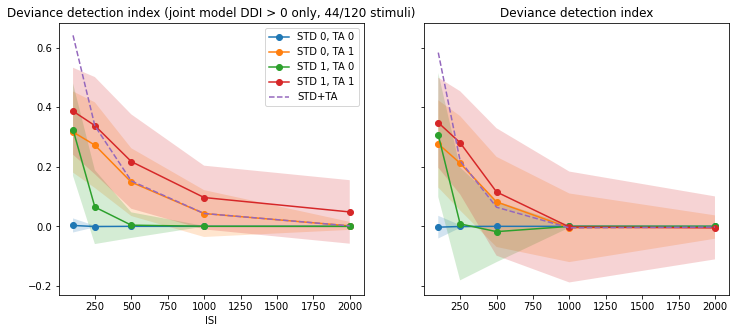

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)
summed, summed_all = 0, 0
n0, n1 = [nspikes[cond][ii.getindex(cfg, STD=1, TA=1)[:-1]].mean(-1)
          for cond in ('dev', 'msc')]  # templ, net, isi, pair, stim
ddi = np.moveaxis(((n0-n1)/(n0+n1)), 2, 0)  # isi, templ, net, pair, stim
ddi_perstim = ddi.mean(axis=1)
mask = (ddi_perstim <= 0).sum(axis=0) == 0  # net, pair, stim

for STD in cfg.STDs:
    for TA in cfg.TAs:
        n0, n1 = [nspikes[cond][ii.getindex(cfg, STD=STD, TA=TA)[:-1]].mean(-1)
                  for cond in ('dev', 'msc')]
        ddi = np.moveaxis(((n0-n1)/(n0+n1)), 2, 0)[:, :, mask]
        ddi_mean = ddi.mean(axis=tuple(range(1, len(ddi.shape))))
        ddi_std = ddi.std(axis=tuple(range(1, len(ddi.shape))))
        axs[0].fill_between(cfg.ISIs, ddi_mean-ddi_std, ddi_mean+ddi_std, alpha=.2)
        axs[0].plot(cfg.ISIs, ddi_mean, '-o', label=f'STD {STD}, TA {TA}')
        if STD+TA == 1:
            summed = summed + ddi_mean
        
        ddi_all = np.moveaxis(((n0-n1)/(n0+n1)), 2, 0)
        ddi_all_mean = ddi_all.mean(axis=tuple(range(1, len(ddi_all.shape))))
        ddi_all_std = ddi_all.std(axis=tuple(range(1, len(ddi_all.shape))))
        axs[1].fill_between(cfg.ISIs, ddi_all_mean-ddi_all_std, ddi_all_mean+ddi_all_std, alpha=.2)
        axs[1].plot(cfg.ISIs, ddi_all_mean, '-o', label=f'STD {STD}, TA {TA}')
        if STD+TA == 1:
            summed_all = summed_all + ddi_all_mean
axs[0].plot(cfg.ISIs, summed, '--', label='STD+TA')
axs[0].set_title(f'Deviance detection index (joint model DDI > 0 only, {mask.sum()}/{mask.size} stimuli)')
axs[0].set_xlabel('ISI')
axs[0].legend()
axs[1].plot(cfg.ISIs, summed_all, '--', label='STD+TA')
axs[1].set_title(f'Deviance detection index');

WARNING    /tmp/ipykernel_618633/2299026720.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 5, figsize=(30,4))
 [py.warnings]


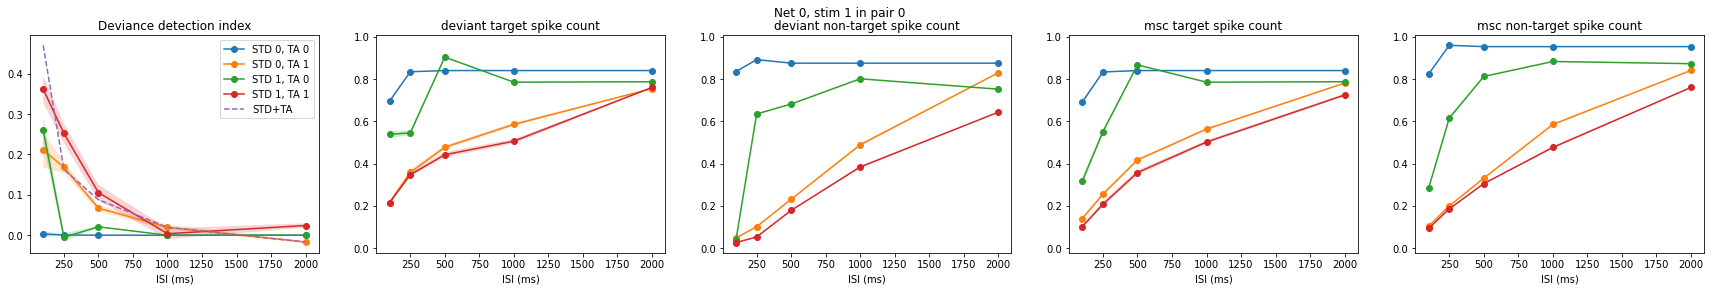

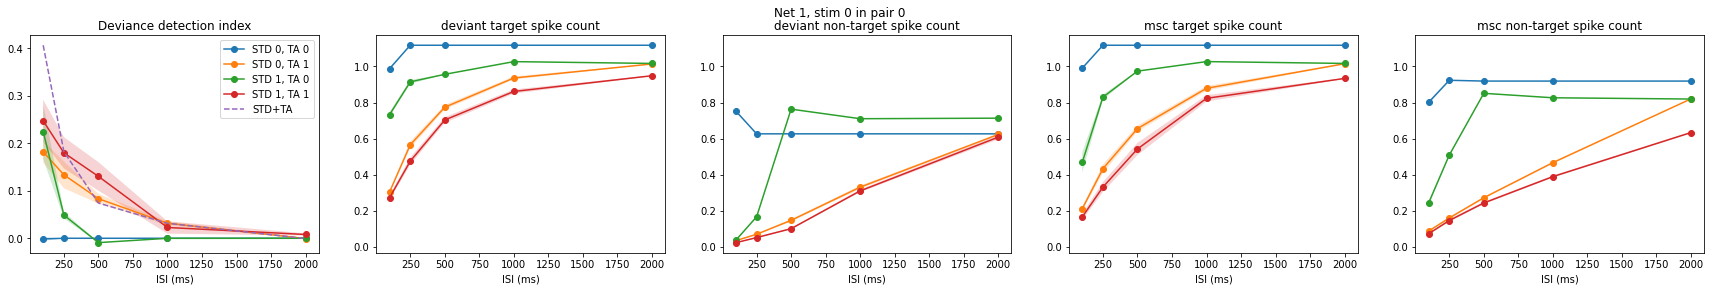

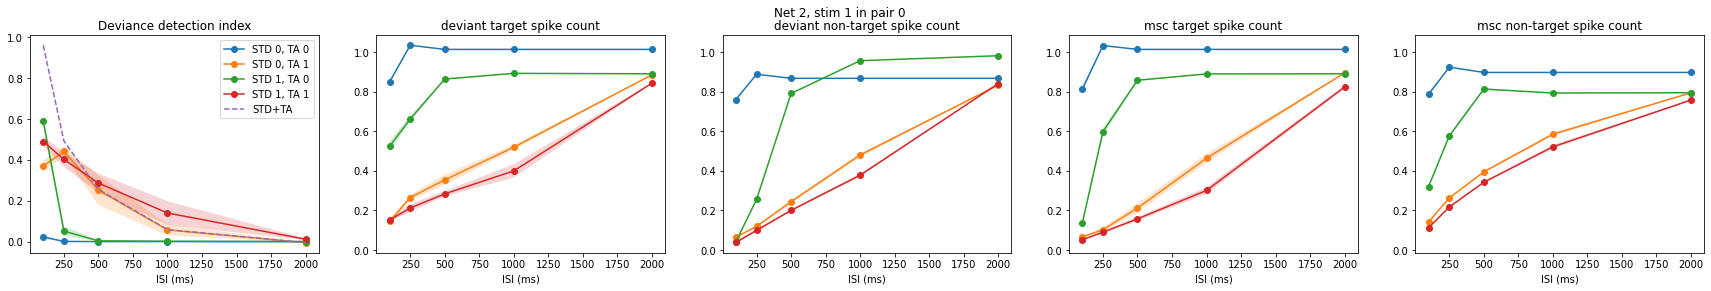

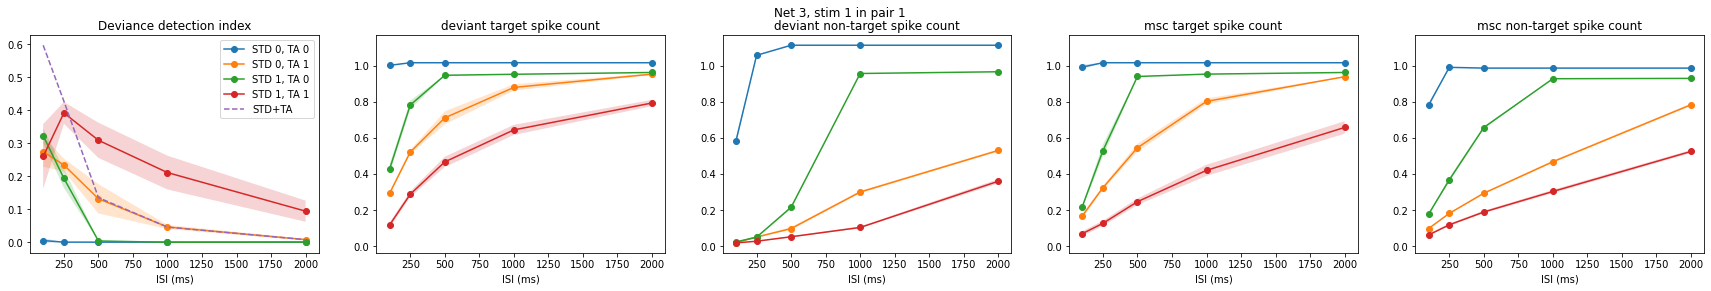

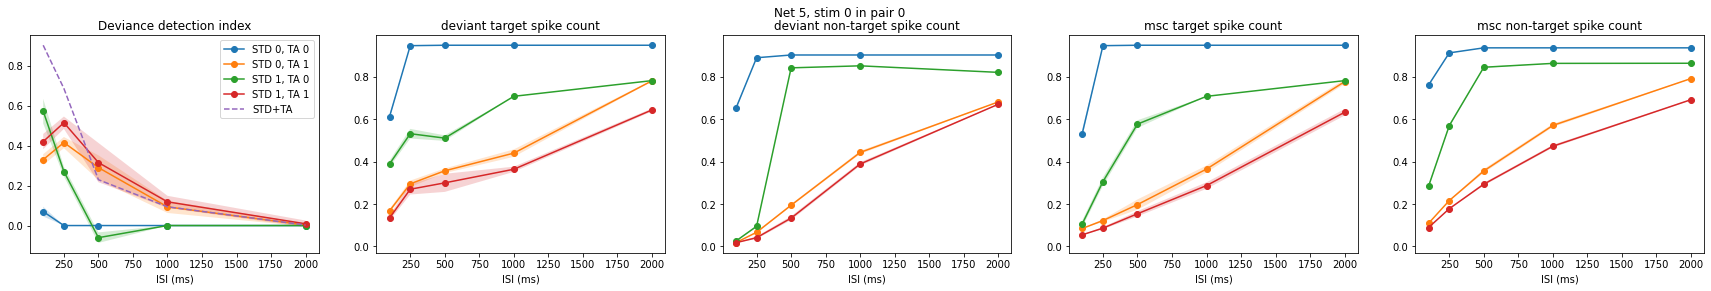

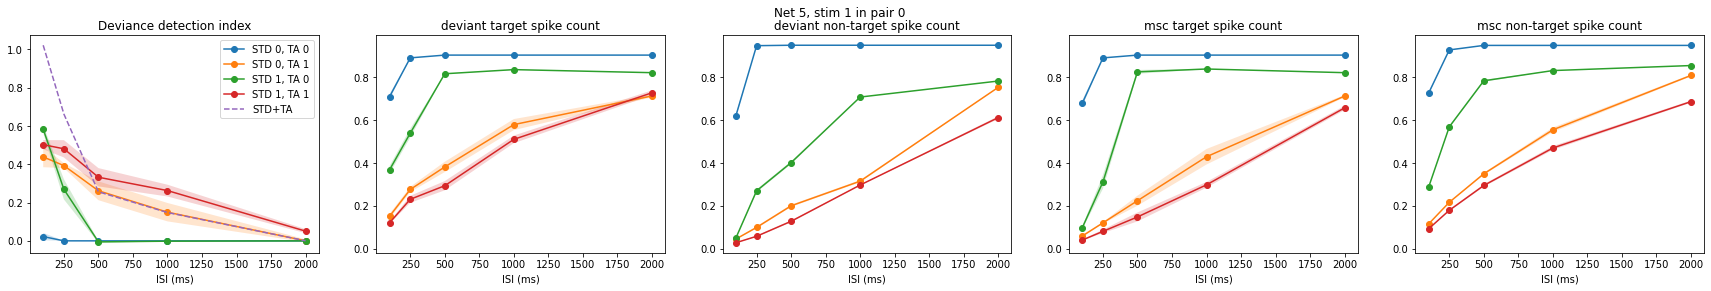

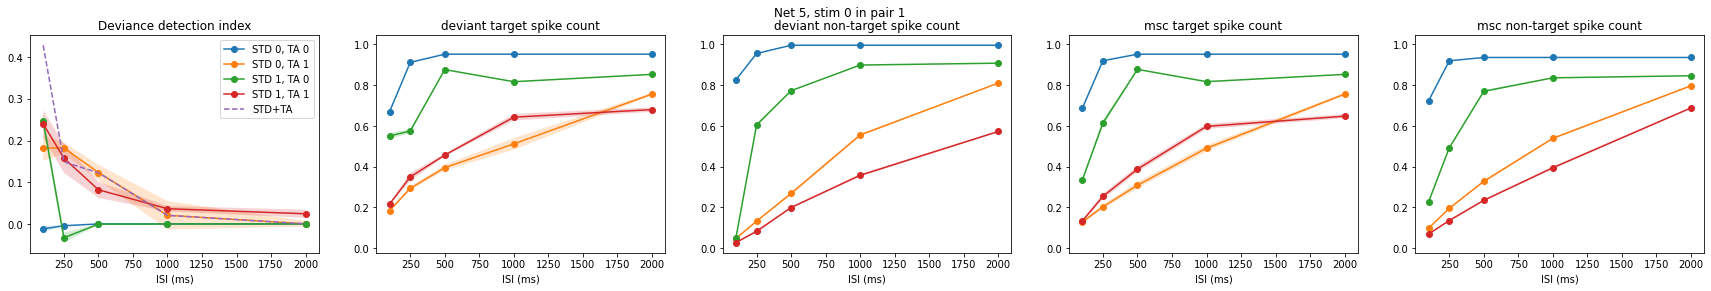

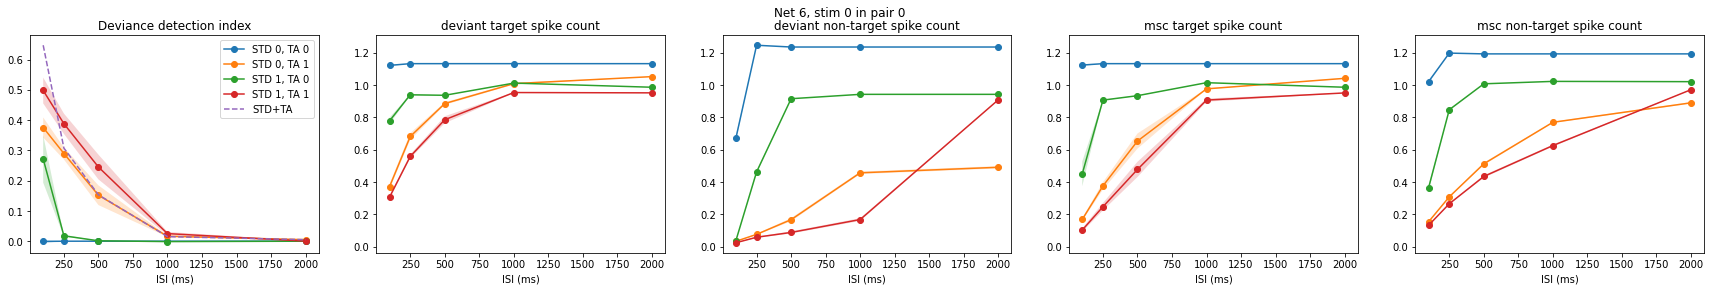

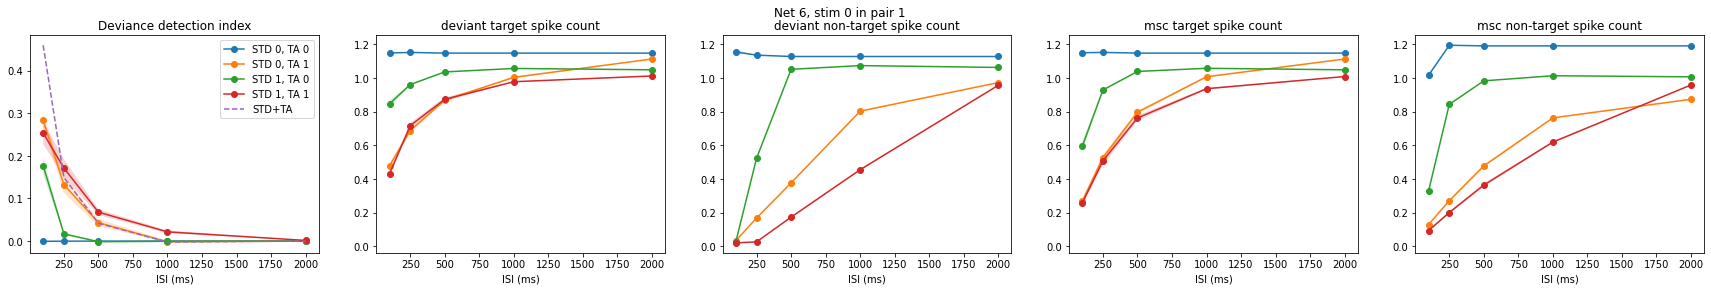

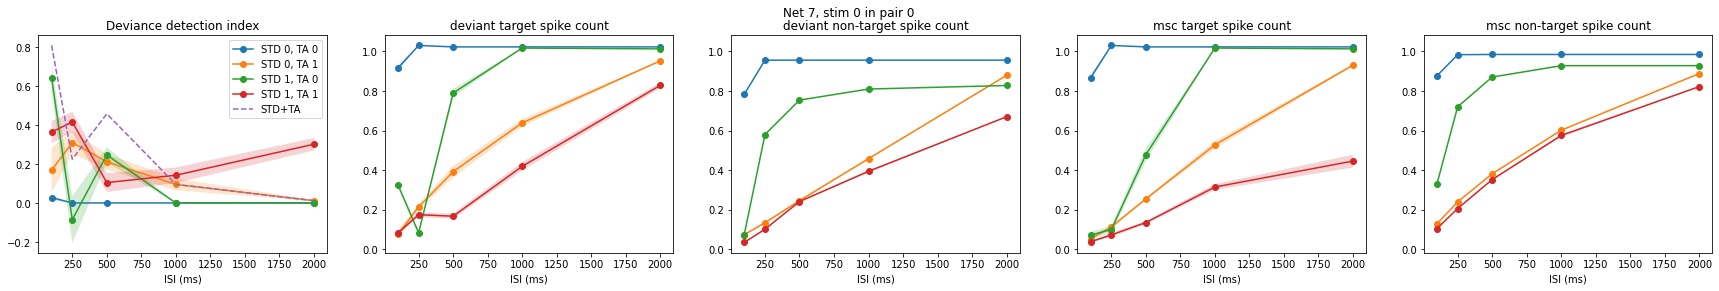

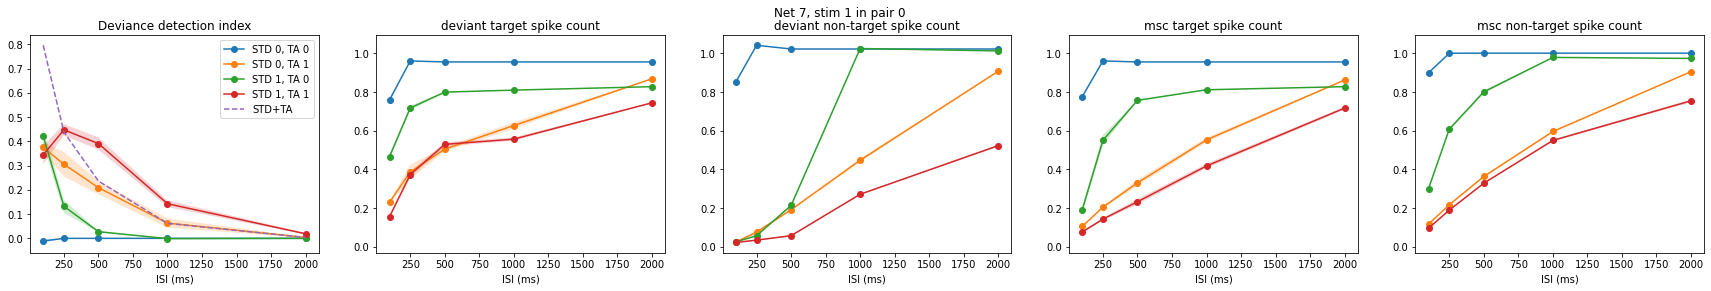

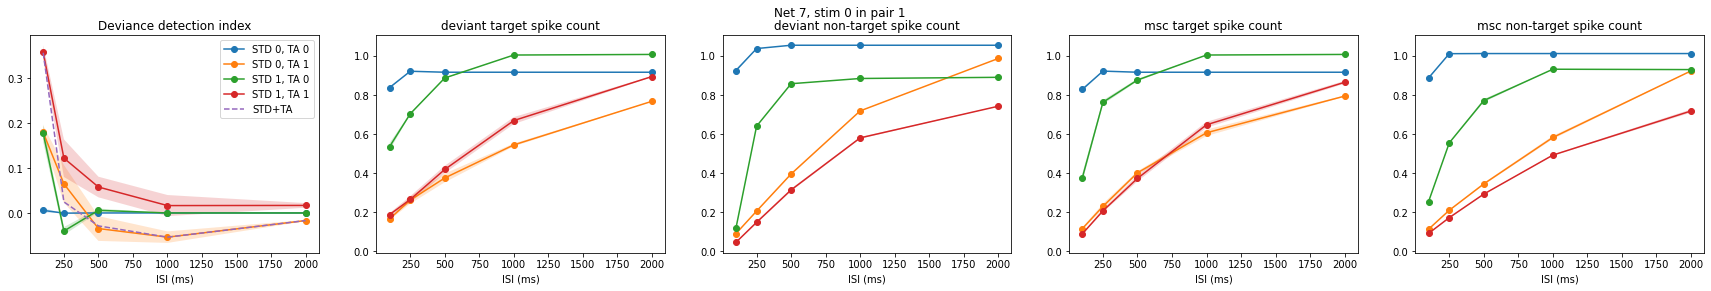

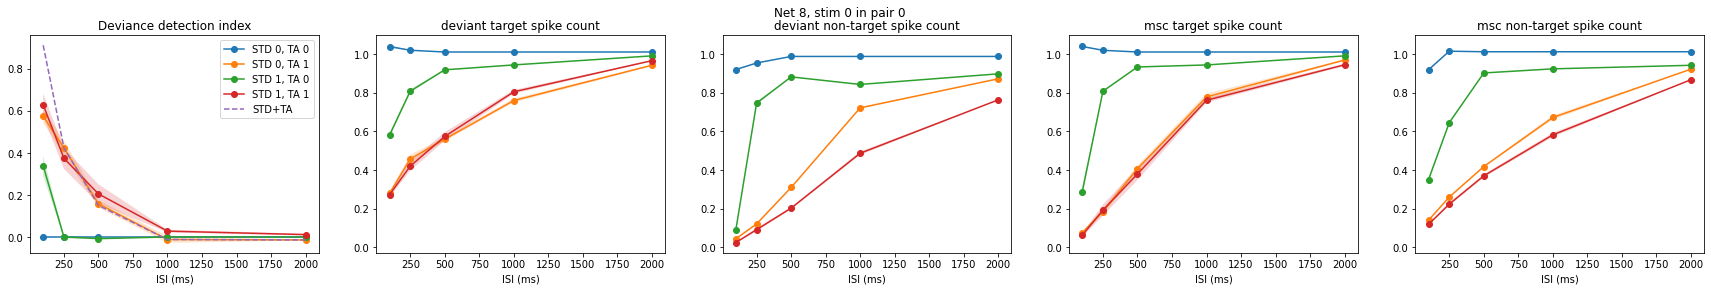

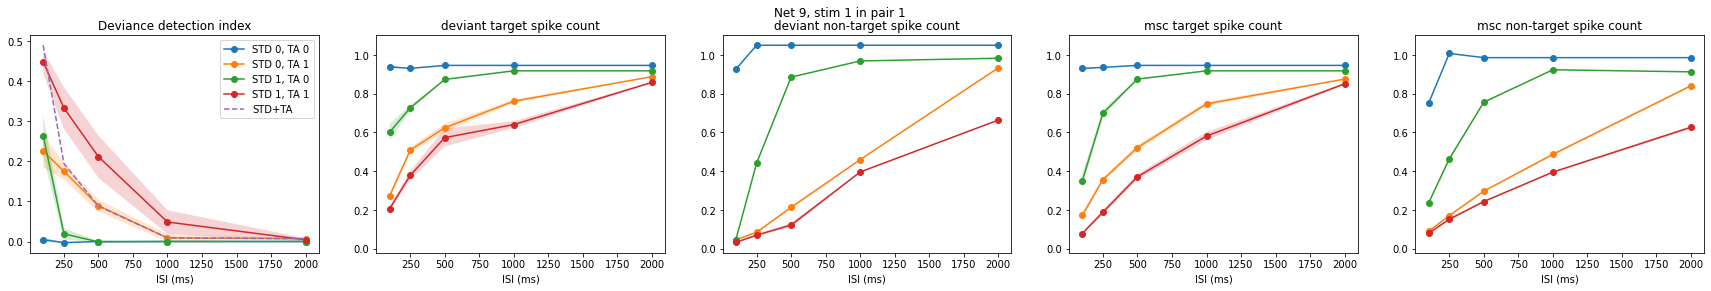

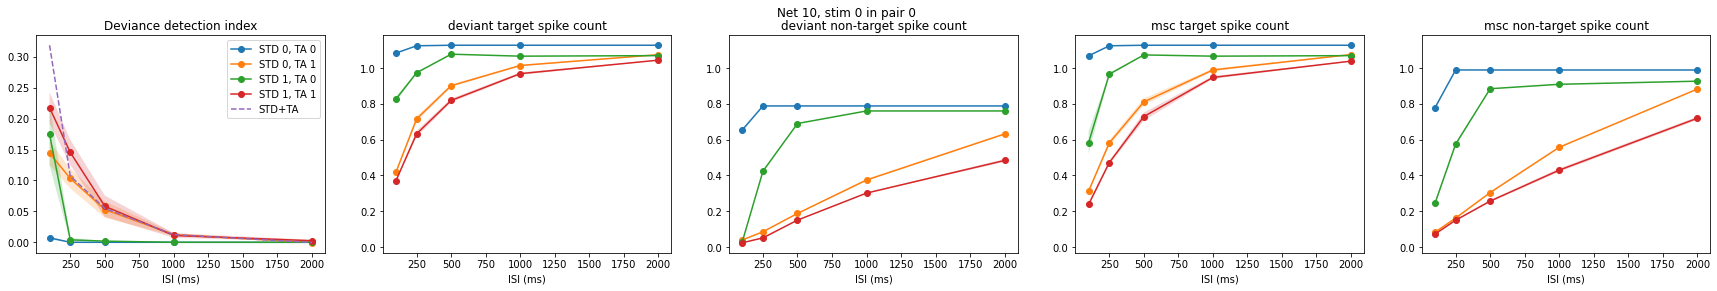

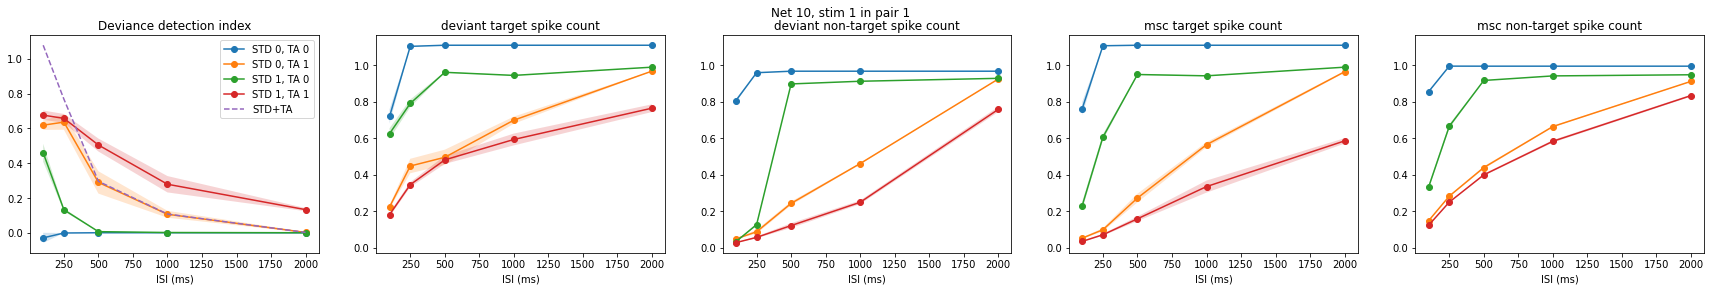

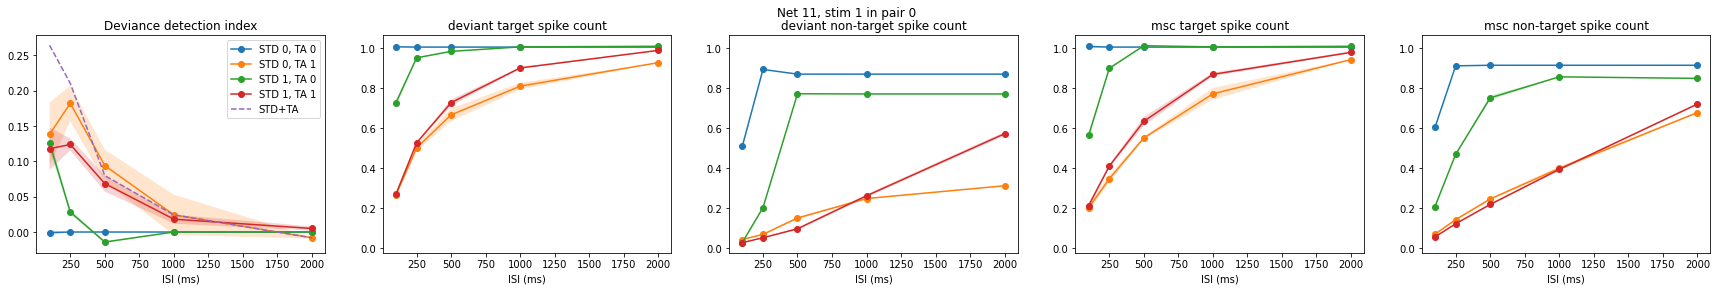

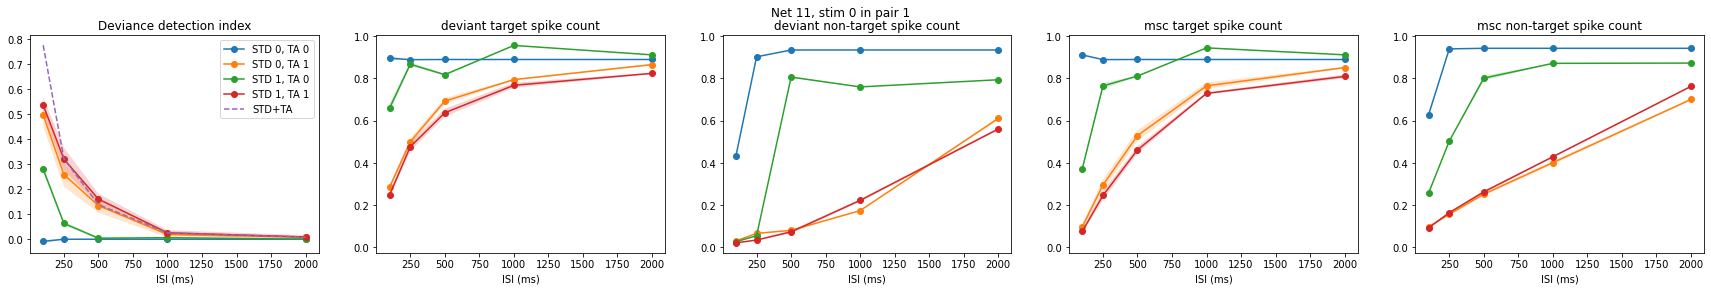

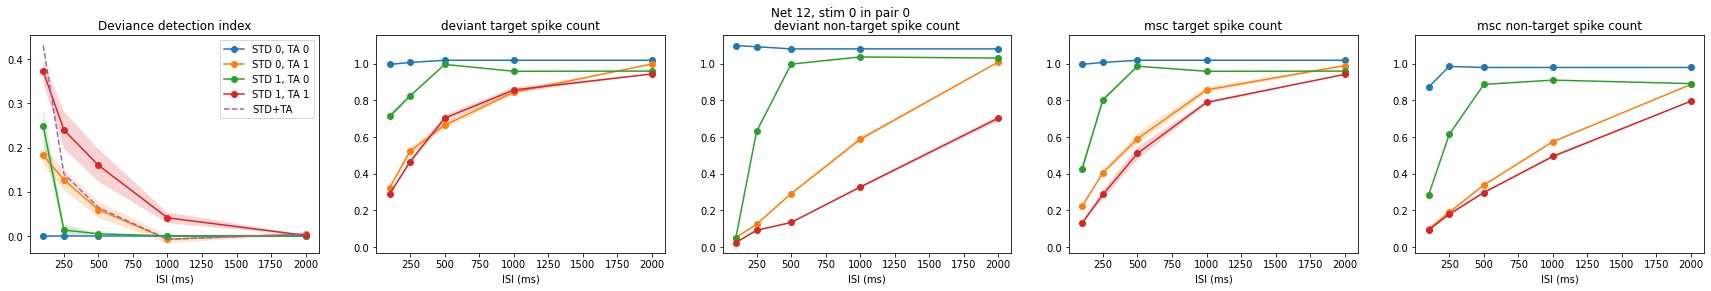

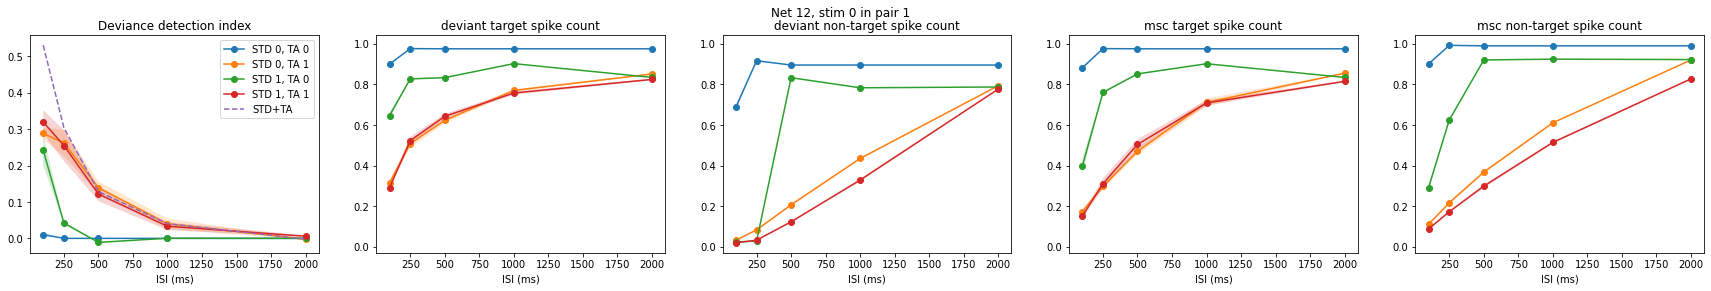

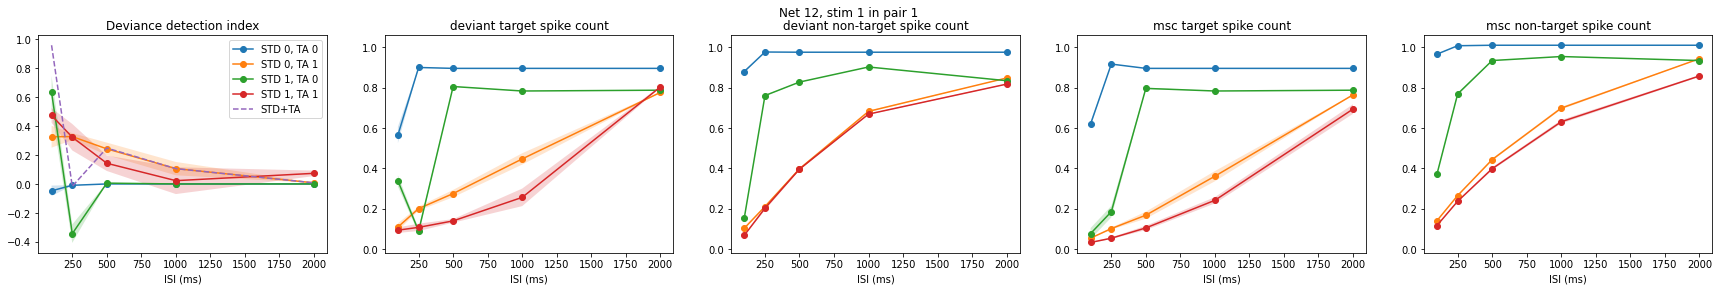

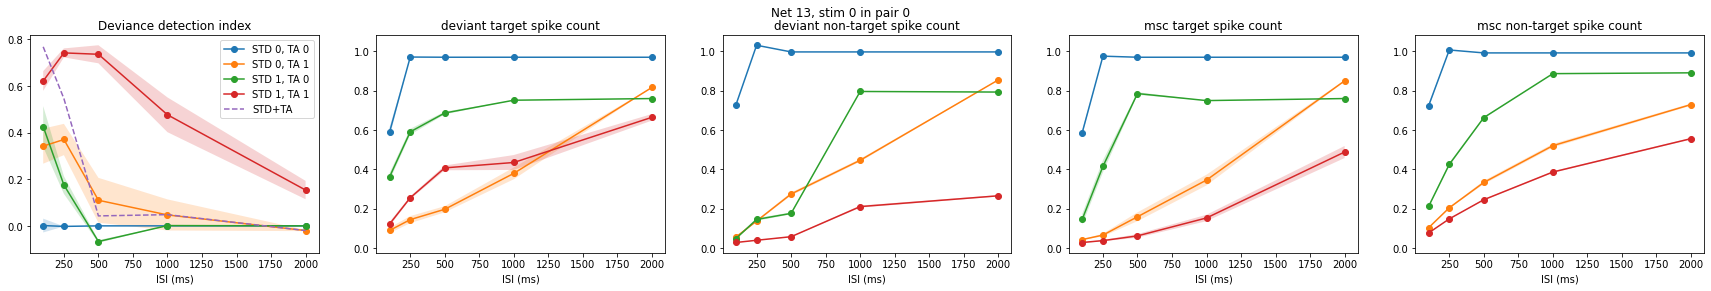

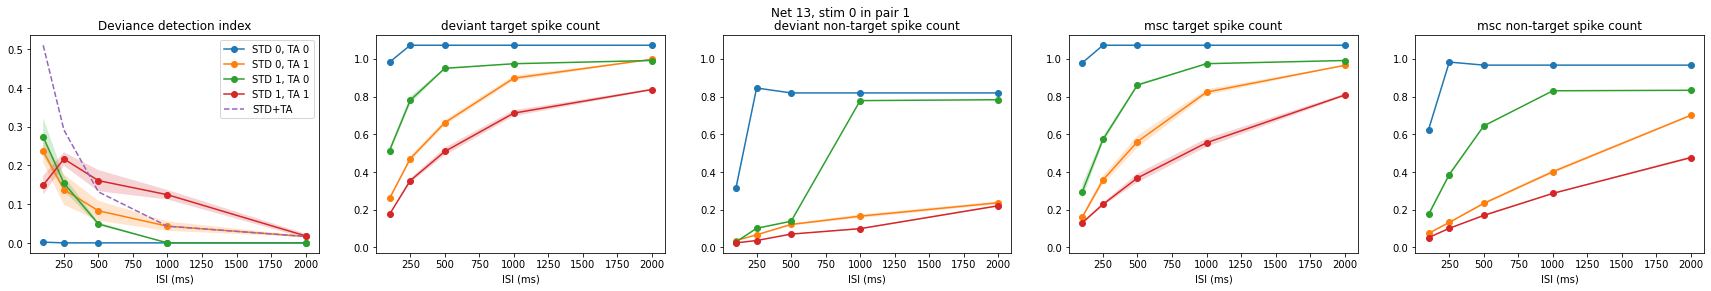

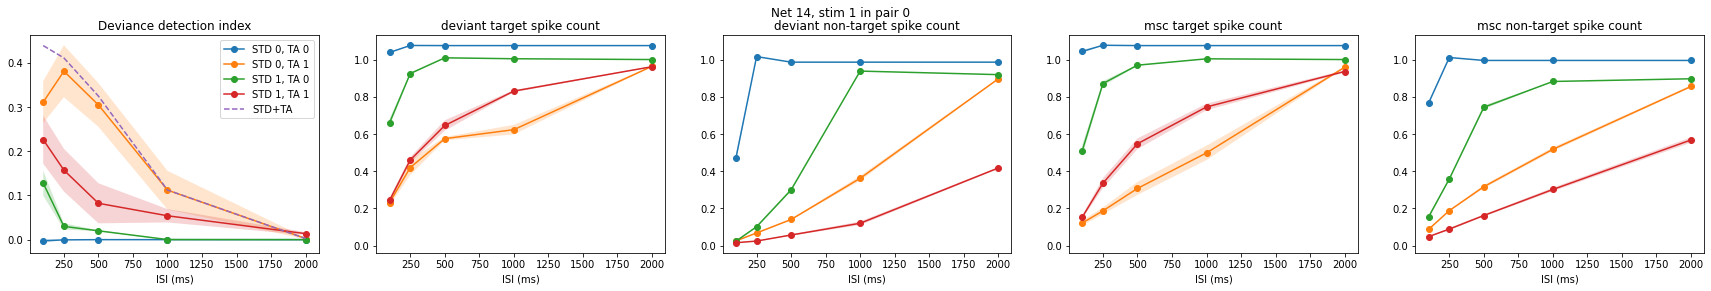

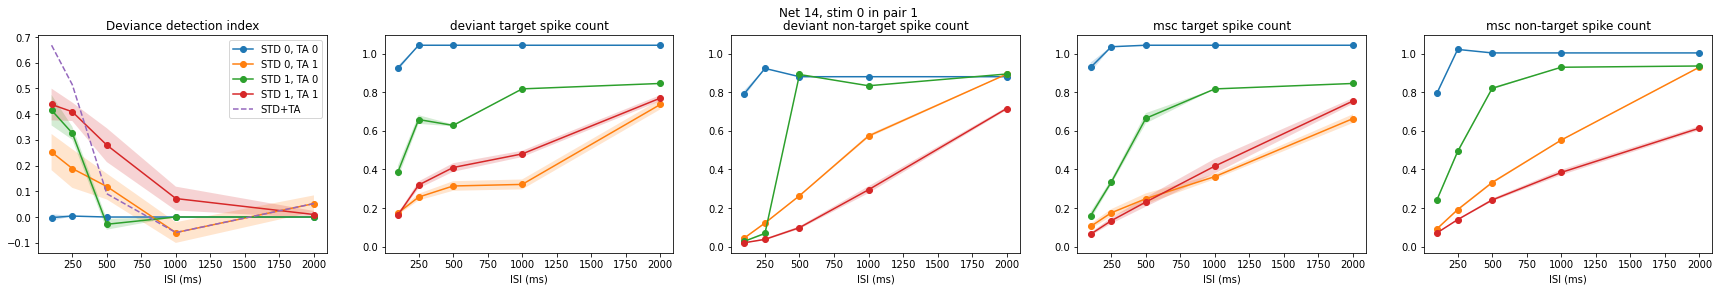

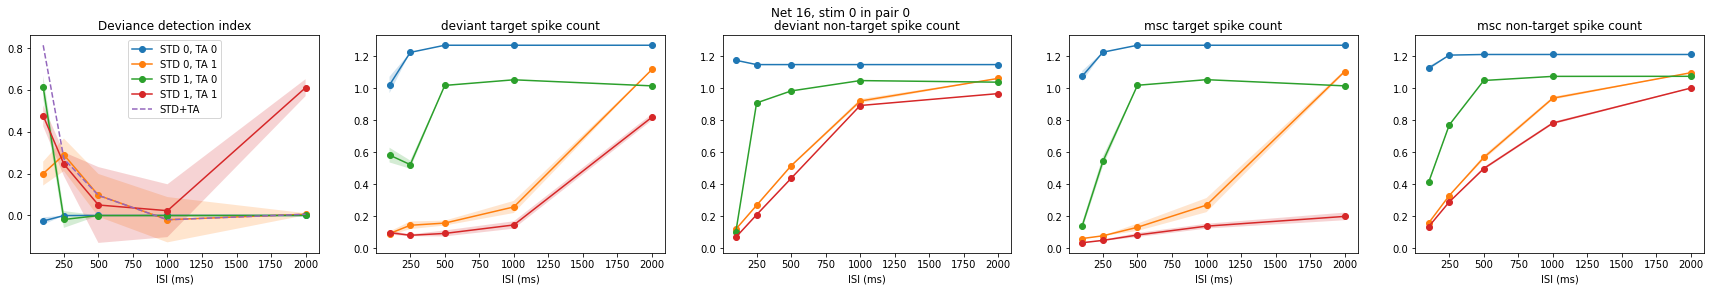

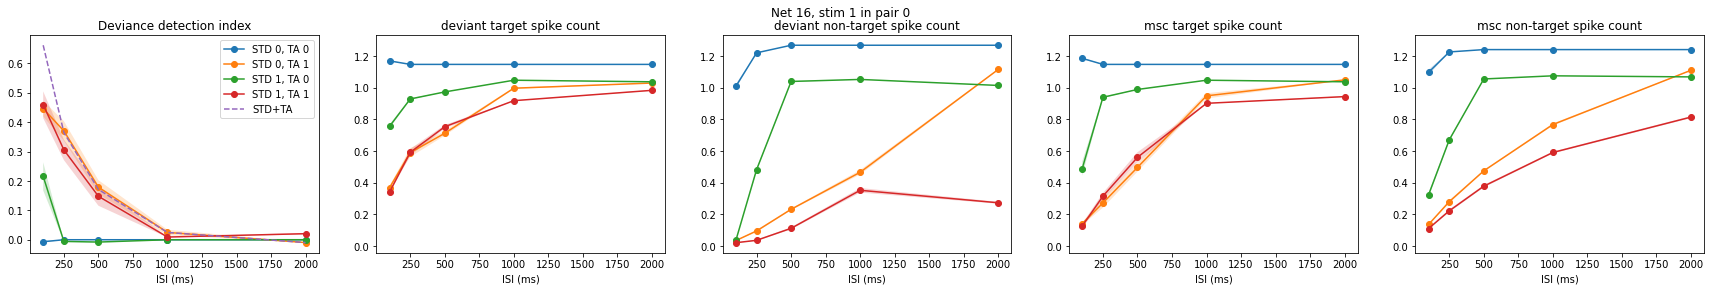

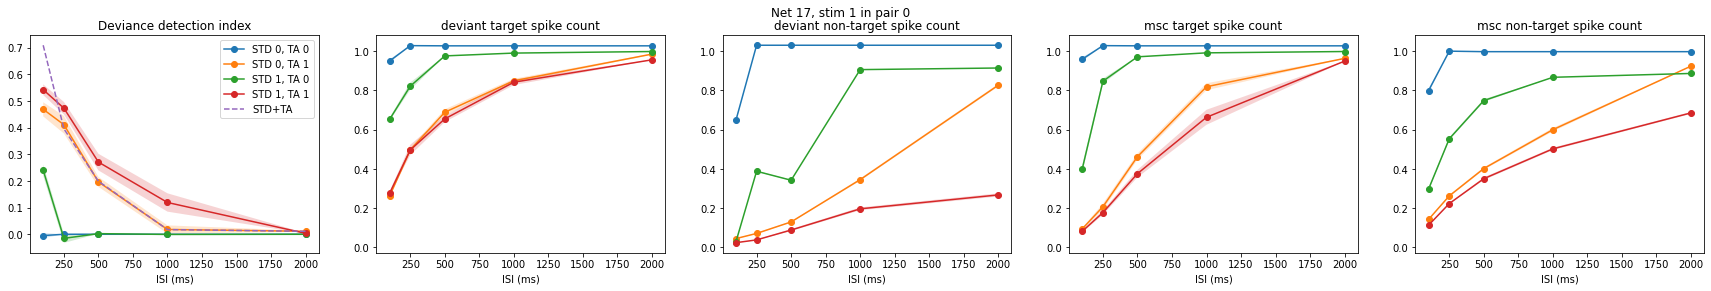

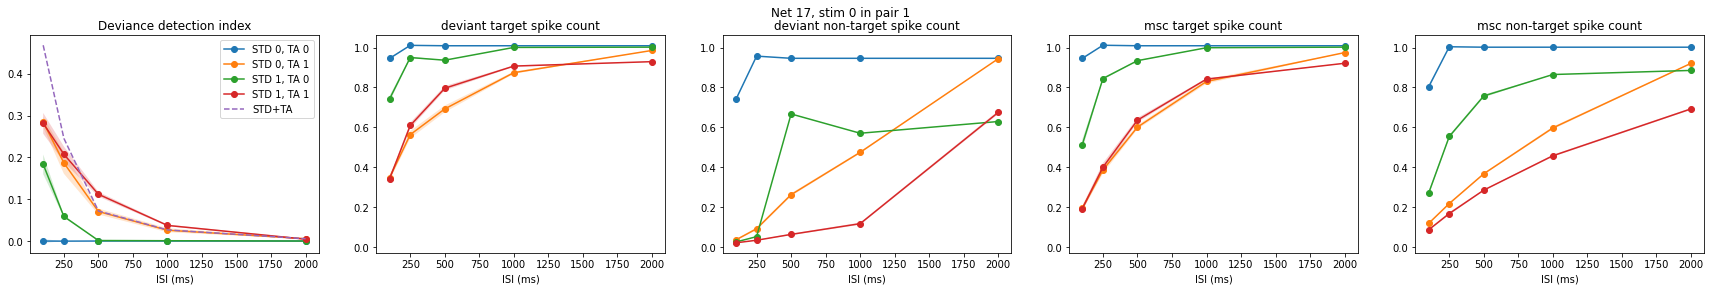

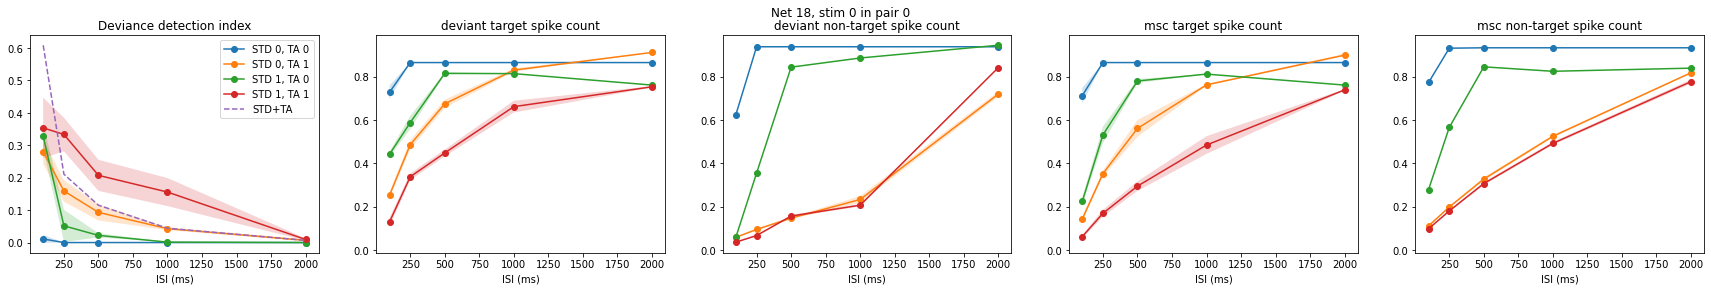

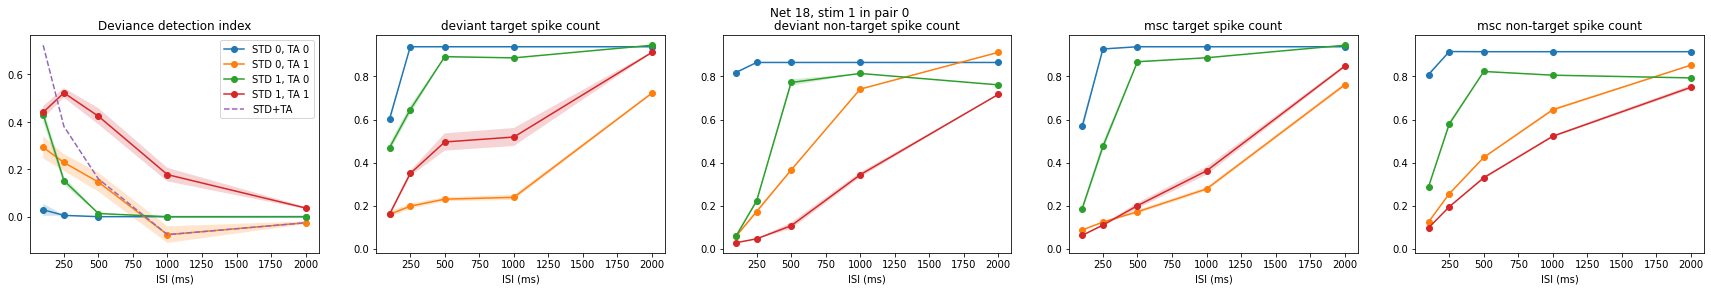

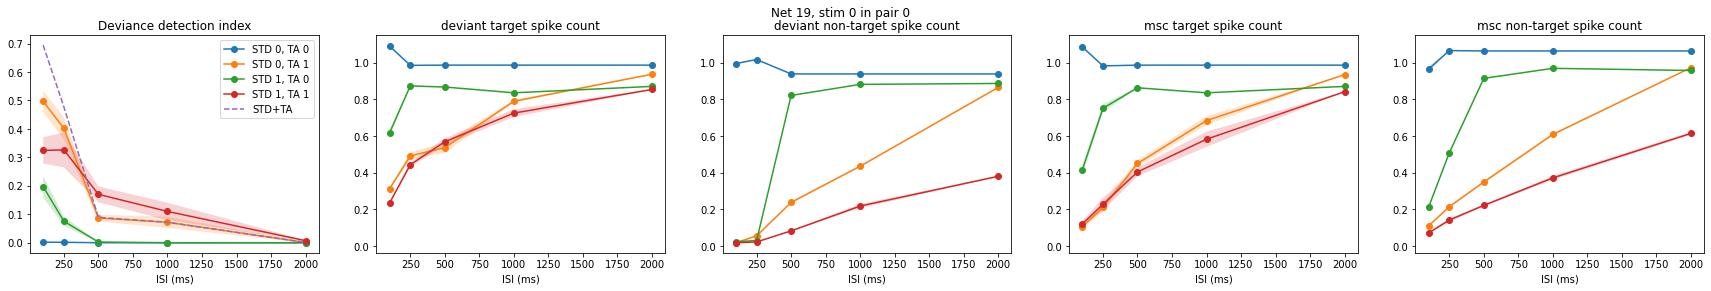

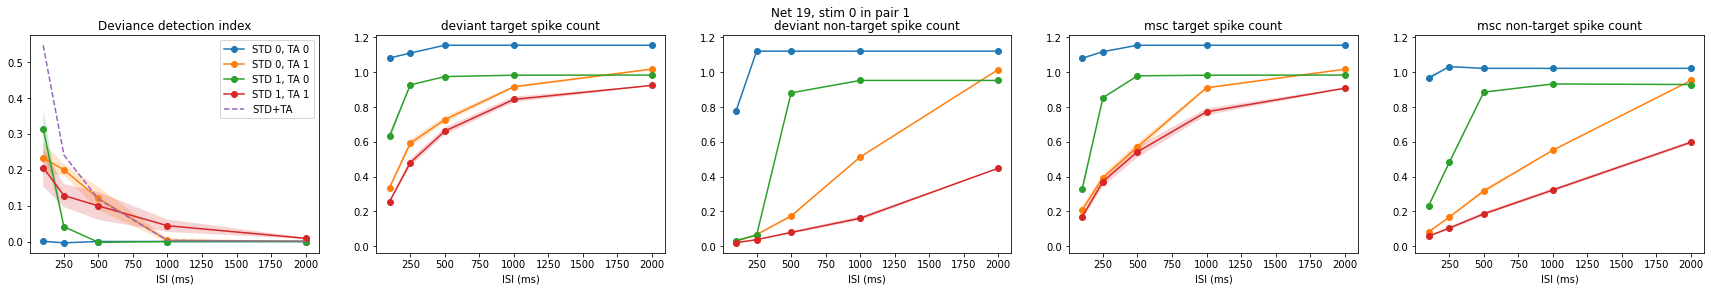

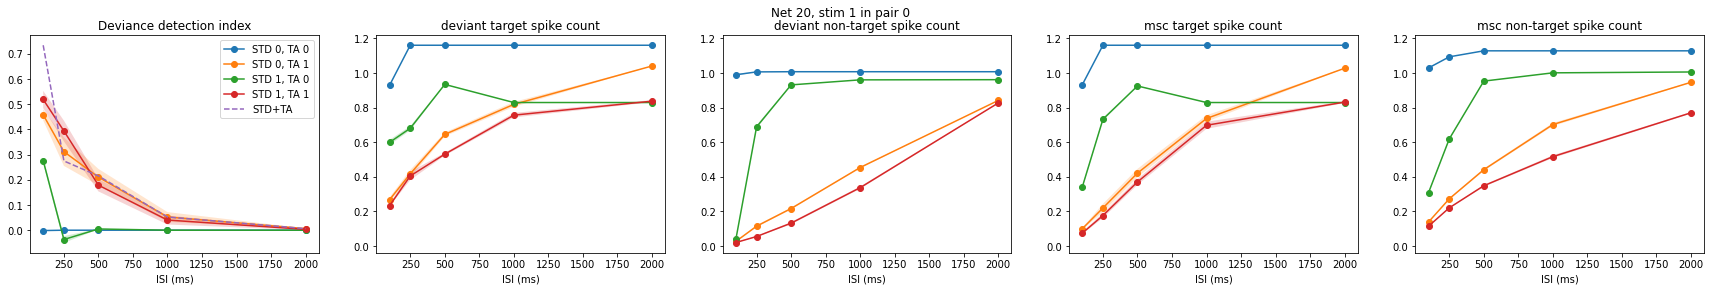

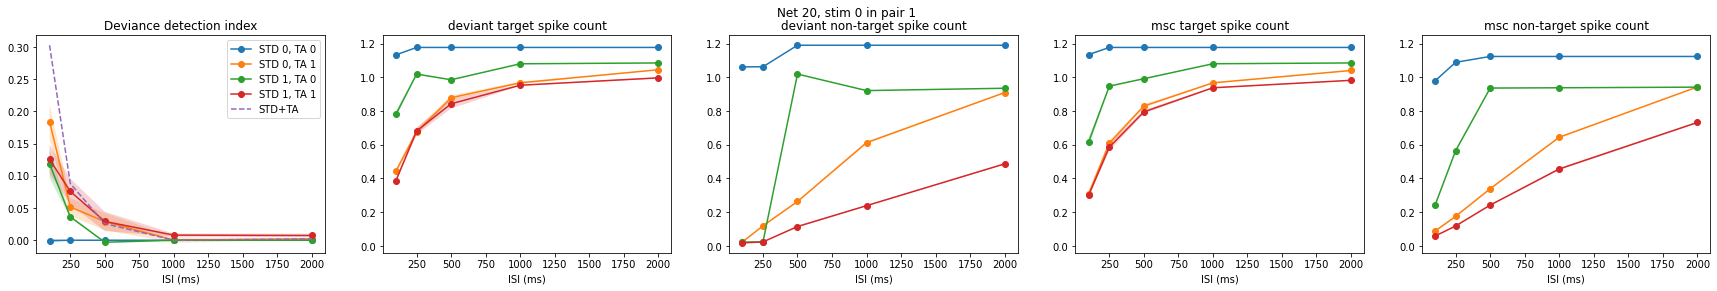

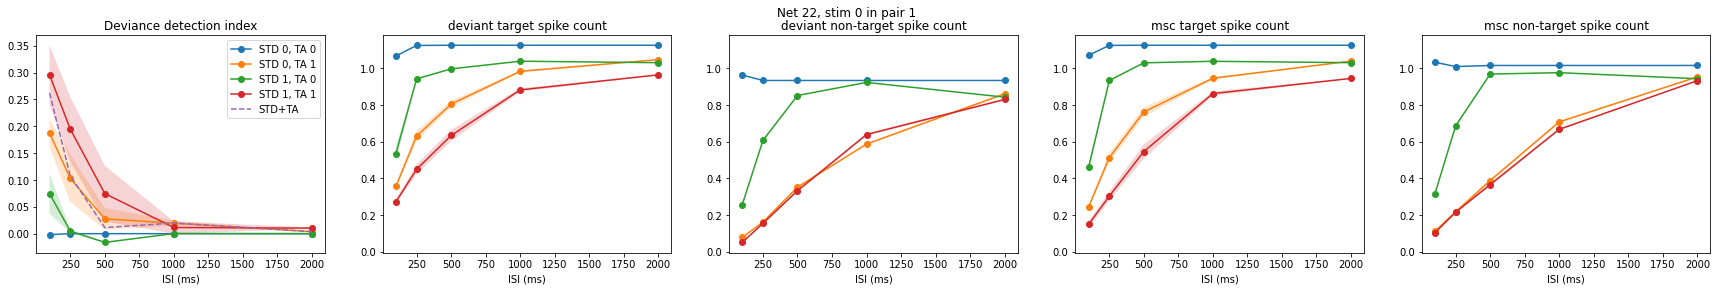

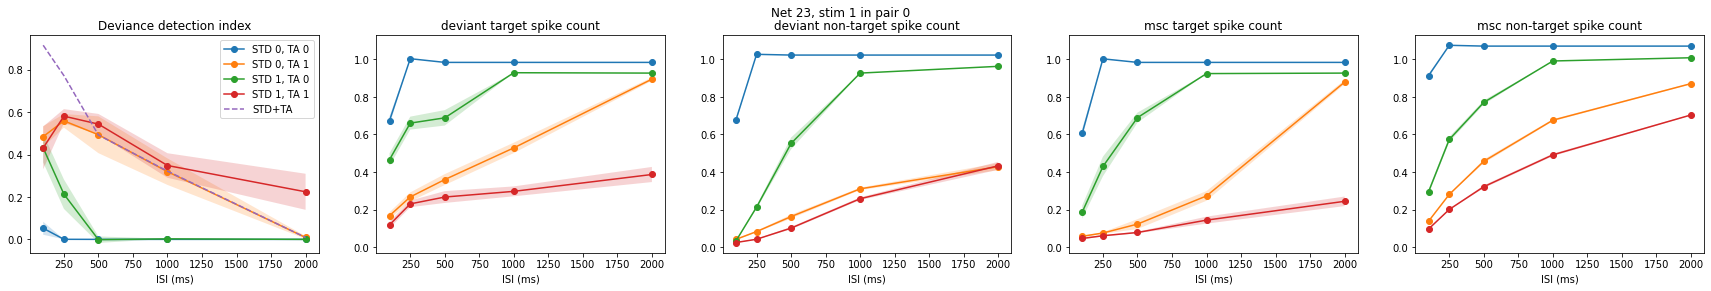

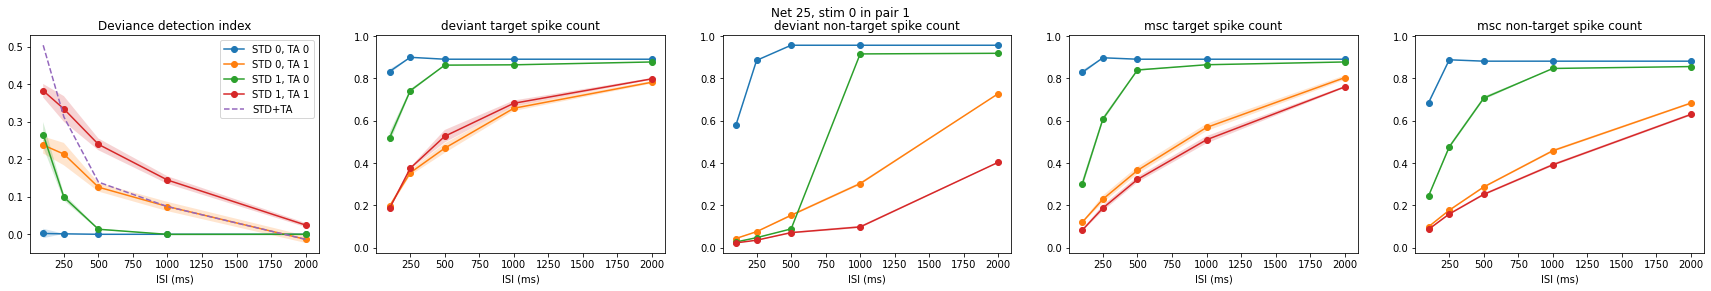

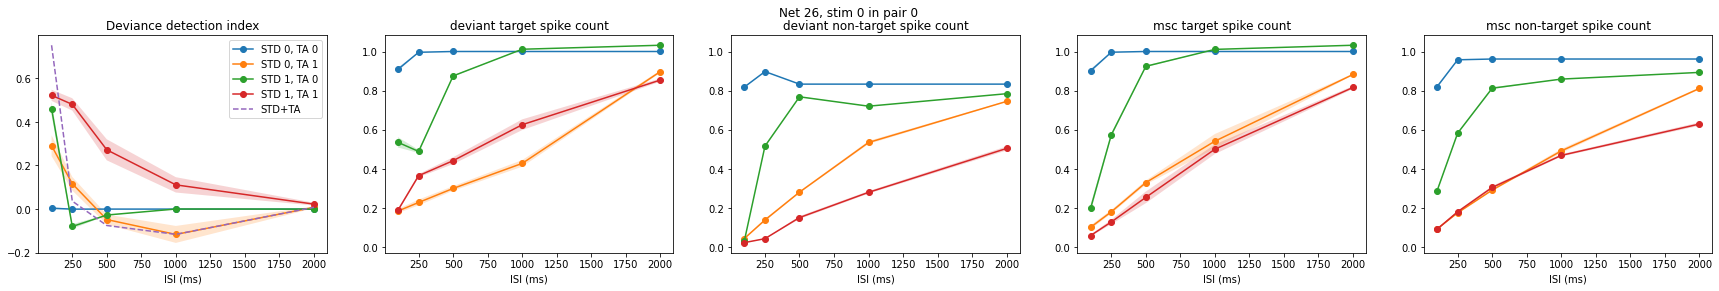

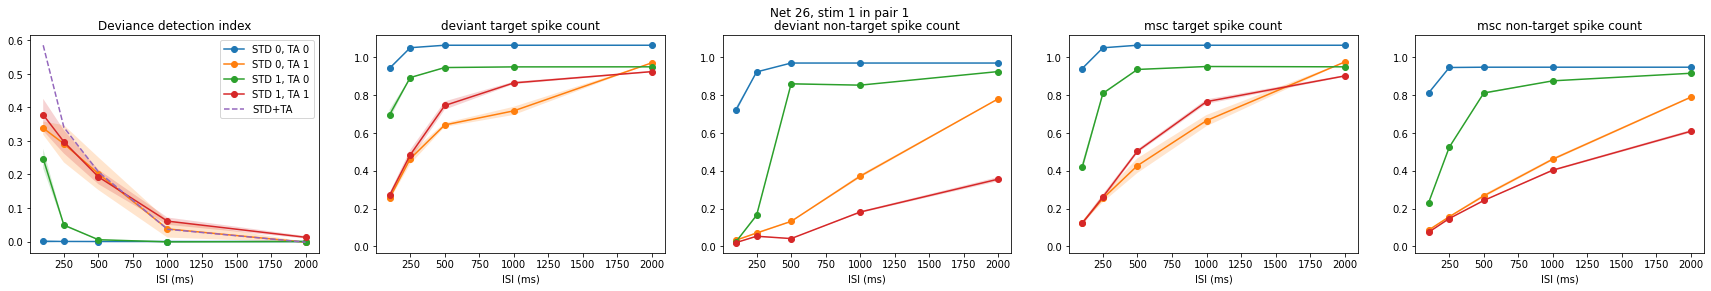

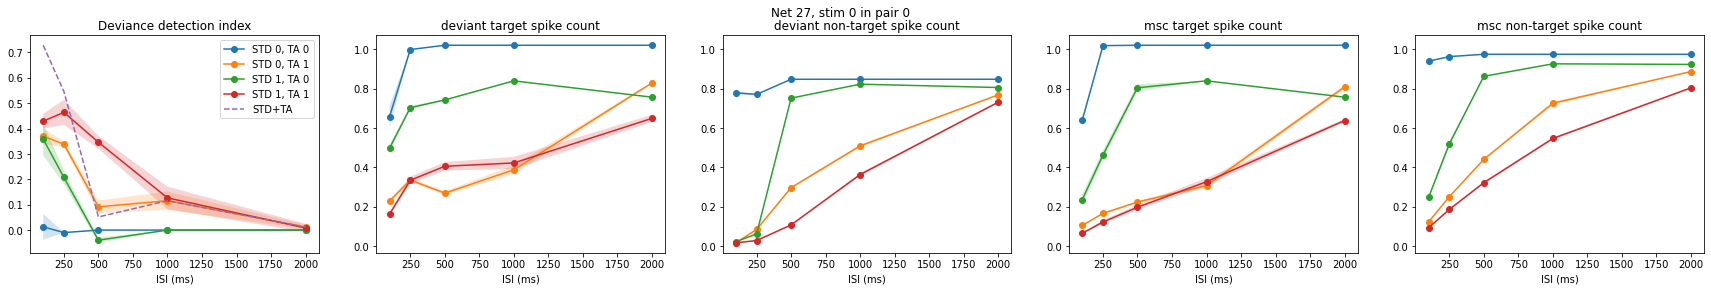

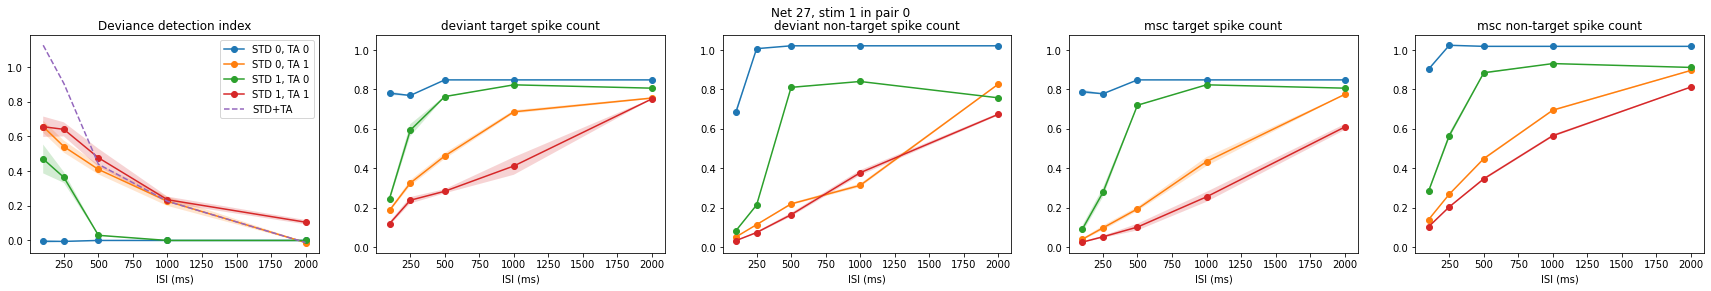

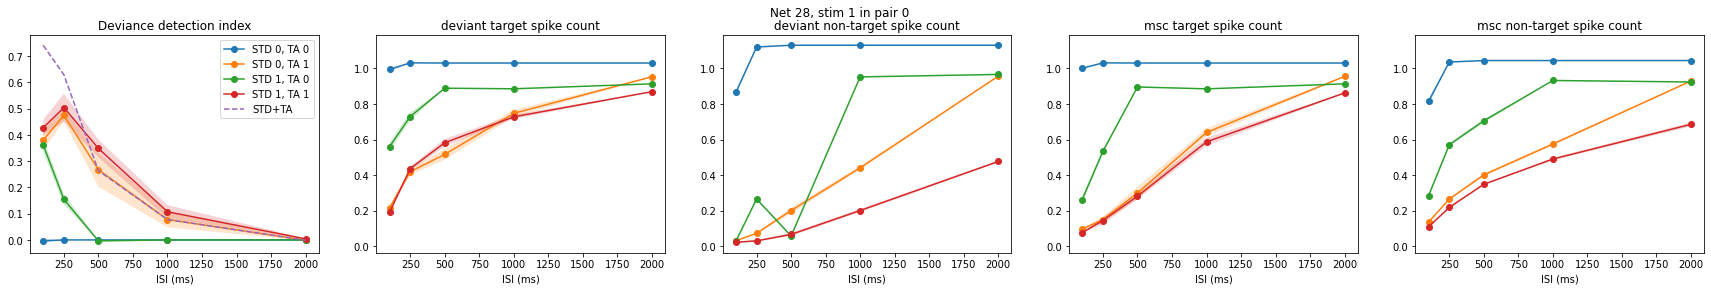

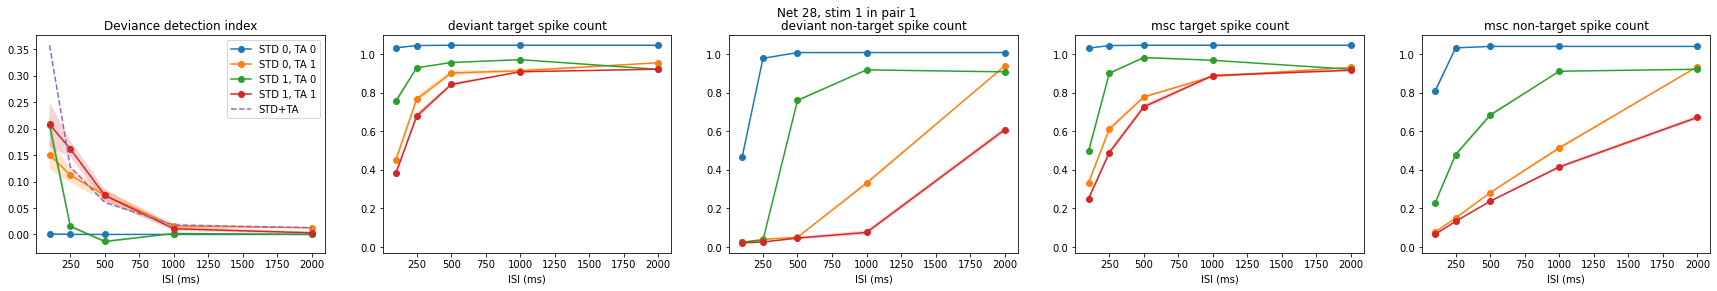

In [5]:
for net, mask_ in enumerate(mask):
 for ipair, mask__ in enumerate(mask_):
  for istim, valid in enumerate(mask__):
    if not valid:
        continue
    fig, axs = plt.subplots(1, 5, figsize=(30,4))
    axs[1].get_shared_y_axes().join(axs[1], *axs[1:])
    fig.suptitle(f'Net {net}, stim {istim} in pair {ipair}')
    summed = 0
    for STD in cfg.STDs:
        for TA in cfg.TAs:
            n0, n1 = [nspikes[cond][ii.getindex(cfg, net=net, STD=STD, TA=TA, ipair=ipair, istim=istim)[:-1]].mean(-1)
                      for cond in ('dev', 'msc')]  # templ, isi
            ddi = (n0-n1)/(n0+n1)
            the_mean = ddi.mean(0)
            the_std = ddi.std(0)
            axs[0].fill_between(cfg.ISIs, the_mean-the_std, the_mean+the_std, alpha=.2)
            axs[0].plot(cfg.ISIs, the_mean, '-o', label=f'STD {STD}, TA {TA}')
            if STD+TA == 1:
                summed = summed + the_mean
            
            the_mean, the_std = n0.mean(0), n0.std(0)
            axs[1].fill_between(cfg.ISIs, the_mean-the_std, the_mean+the_std, alpha=.2)
            axs[1].plot(cfg.ISIs, the_mean, '-o')
            
            n0_nontarget = nspikes['std'][ii.getindex(cfg, net=net, STD=STD, TA=TA, ipair=ipair, istim=(1-istim))[:-1]].mean(-1)
            the_mean, the_std = n0_nontarget.mean(0), n0_nontarget.std(0)
            axs[2].fill_between(cfg.ISIs, the_mean-the_std, the_mean+the_std, alpha=.2)
            axs[2].plot(cfg.ISIs, the_mean, '-o')
            
            the_mean, the_std = n1.mean(0), n1.std(0)
            axs[3].fill_between(cfg.ISIs, the_mean-the_std, the_mean+the_std, alpha=.2)
            axs[3].plot(cfg.ISIs, the_mean, '-o')
            
            n1_nontarget = nspikes['nontarget_msc'][ii.getindex(cfg, net=net, STD=STD, TA=TA, ipair=ipair, istim=istim)[:-1]].mean(-1)
            the_mean, the_std = n1_nontarget.mean(0), n1_nontarget.std(0)
            axs[4].fill_between(cfg.ISIs, the_mean-the_std, the_mean+the_std, alpha=.2)
            axs[4].plot(cfg.ISIs, the_mean, '-o')

    axs[0].plot(cfg.ISIs, summed, '--', label='STD+TA')

    for ax, title in zip(axs, ('Deviance detection index', 'deviant target spike count', 'deviant non-target spike count',
                               'msc target spike count', 'msc non-target spike count')):
        ax.set_title(title)
        ax.set_xlabel('ISI (ms)')
    axs[0].legend()

In [6]:
def get_ddi(nspikes, **kwargs):
    n0, n1 = [nspikes[cond][ii.getindex(cfg, **kwargs)[:-1]].mean(-1)
              for cond in ('dev', 'msc')]  # templ, isi
    ddi = (n0-n1)/(n0+n1)
    return ddi.mean(0), ddi.std(0)

In [7]:
i = 0
full_model_ddi, summation_ddi = np.empty((2, mask.sum(), len(cfg.ISIs)))
all_fm_ddi, all_sum_ddi = np.empty((2, mask.size, len(cfg.ISIs)))
for net, mask_ in enumerate(mask):
 for ipair, mask__ in enumerate(mask_):
  for istim, valid in enumerate(mask__):
    fullmodel, _ = get_ddi(nspikes, net=net, ipair=ipair, istim=istim, STD=1, TA=1)
    noTA, _ = get_ddi(nspikes, net=net, ipair=ipair, istim=istim, STD=1, TA=0)
    noSTD, _ = get_ddi(nspikes, net=net, ipair=ipair, istim=istim, STD=0, TA=1)
    all_fm_ddi[i] = fullmodel
    all_sum_ddi[i] = noTA + noSTD
    i += 1
full_model_ddi = all_fm_ddi[mask.flatten()]
summation_ddi = all_sum_ddi[mask.flatten()]

# Runs with full-model DDI > 0:

In [8]:
print(mask.sum(), '/', mask.size, 'runs selected')

44 / 120 runs selected


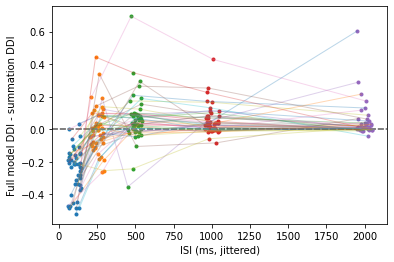

In [9]:
jitter = np.random.uniform(-50, 50, full_model_ddi.shape) + cfg.ISIs
for isi, full_, summ_ in zip(jitter.T, full_model_ddi.T, summation_ddi.T):
    plt.plot(isi, full_-summ_, 'o', ms=3)
    plt.axhline(0, ls='--', color='grey')
plt.plot(jitter.T, (full_model_ddi - summation_ddi).T, lw=1, alpha=.3)
plt.xlabel('ISI (ms, jittered)')
plt.ylabel('Full model DDI - summation DDI');

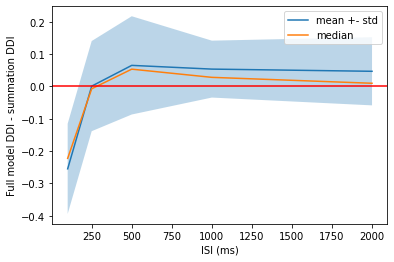

In [10]:
the_mean = np.mean(full_model_ddi - summation_ddi, 0)
the_std = np.std(full_model_ddi - summation_ddi, 0)
plt.fill_between(cfg.ISIs, the_mean+the_std, the_mean-the_std, alpha=.3)
plt.plot(cfg.ISIs, np.mean(full_model_ddi - summation_ddi, 0), label='mean +- std')
plt.plot(cfg.ISIs, np.median(full_model_ddi - summation_ddi, 0), label='median')
plt.axhline(0, color='r')
plt.legend()
plt.ylabel('Full model DDI - summation DDI')
plt.xlabel('ISI (ms)');

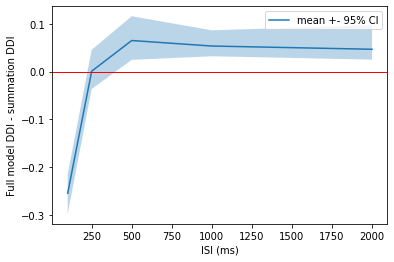

In [11]:
ci_lo, ci_hi = [], []
for ISI, delta in zip(cfg.ISIs, (full_model_ddi-summation_ddi).T):
    b = bootstrap((delta,), np.mean, confidence_level=.95)
    ci_lo.append(b.confidence_interval.low)
    ci_hi.append(b.confidence_interval.high)
plt.fill_between(cfg.ISIs, ci_lo, ci_hi, alpha=.3)
plt.plot(cfg.ISIs, np.mean(full_model_ddi - summation_ddi, 0), label='mean +- 95% CI')
plt.axhline(0, color='r', lw=1)
plt.legend()
plt.ylabel('Full model DDI - summation DDI')
plt.xlabel('ISI (ms)');

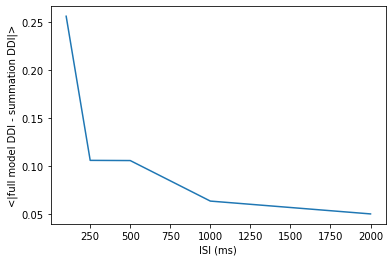

In [12]:
plt.plot(cfg.ISIs, np.abs(full_model_ddi-summation_ddi).mean(0))
plt.xlabel('ISI (ms)')
plt.ylabel('<|full model DDI - summation DDI|>');

WARNING    /tmp/ipykernel_618633/1999508473.py:1: RuntimeWarning: invalid value encountered in log
  logratio = np.log(full_model_ddi / summation_ddi)
 [py.warnings]


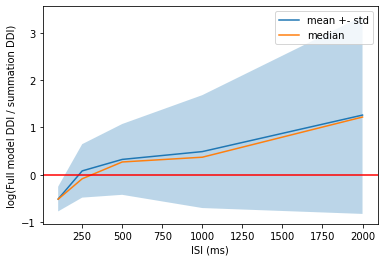

In [13]:
logratio = np.log(full_model_ddi / summation_ddi)
the_mean = np.nanmean(logratio, 0)
the_std = np.nanstd(logratio, 0)
plt.fill_between(cfg.ISIs, the_mean+the_std, the_mean-the_std, alpha=.3)
plt.plot(cfg.ISIs, the_mean, label='mean +- std')
plt.plot(cfg.ISIs, np.nanmedian(logratio, 0), label='median')
plt.axhline(0, color='r')
plt.legend()
plt.ylabel('log(Full model DDI / summation DDI)')
plt.xlabel('ISI (ms)');

# All runs

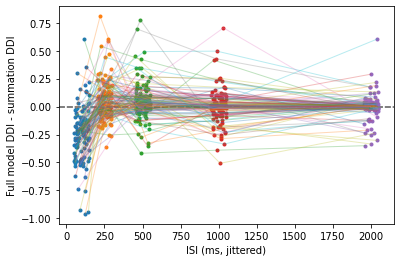

In [14]:
jitter = np.random.uniform(-50, 50, all_fm_ddi.shape) + cfg.ISIs
for isi, full_, summ_ in zip(jitter.T, all_fm_ddi.T, all_sum_ddi.T):
    plt.plot(isi, full_-summ_, 'o', ms=3)
    plt.axhline(0, ls='--', color='grey')
plt.plot(jitter.T, (all_fm_ddi - all_sum_ddi).T, lw=1, alpha=.3)
plt.xlabel('ISI (ms, jittered)')
plt.ylabel('Full model DDI - summation DDI');

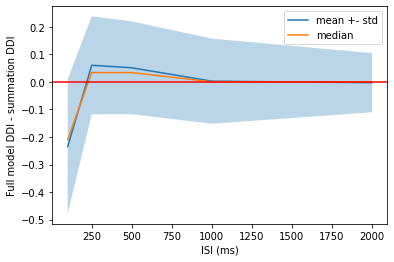

In [15]:
the_mean = np.mean(all_fm_ddi - all_sum_ddi, 0)
the_std = np.std(all_fm_ddi - all_sum_ddi, 0)
plt.fill_between(cfg.ISIs, the_mean+the_std, the_mean-the_std, alpha=.3)
plt.plot(cfg.ISIs, np.mean(all_fm_ddi - all_sum_ddi, 0), label='mean +- std')
plt.plot(cfg.ISIs, np.median(all_fm_ddi - all_sum_ddi, 0), label='median')
plt.axhline(0, color='r')
plt.legend()
plt.ylabel('Full model DDI - summation DDI')
plt.xlabel('ISI (ms)');

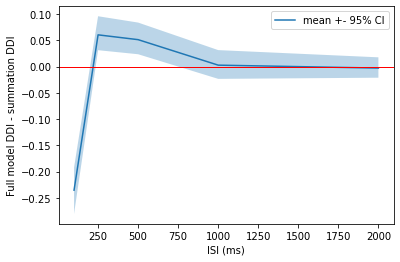

In [16]:
ci_lo, ci_hi = [], []
for ISI, delta in zip(cfg.ISIs, (all_fm_ddi-all_sum_ddi).T):
    b = bootstrap((delta,), np.mean, confidence_level=.95)
    ci_lo.append(b.confidence_interval.low)
    ci_hi.append(b.confidence_interval.high)
plt.fill_between(cfg.ISIs, ci_lo, ci_hi, alpha=.3)
plt.plot(cfg.ISIs, np.mean(all_fm_ddi - all_sum_ddi, 0), label='mean +- 95% CI')
plt.axhline(0, color='r', lw=1)
plt.legend()
plt.ylabel('Full model DDI - summation DDI')
plt.xlabel('ISI (ms)');

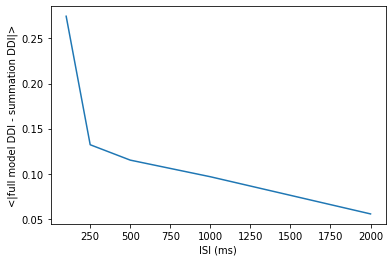

In [17]:
plt.plot(cfg.ISIs, np.abs(all_fm_ddi-all_sum_ddi).mean(0))
plt.xlabel('ISI (ms)')
plt.ylabel('<|full model DDI - summation DDI|>');

WARNING    /tmp/ipykernel_618633/944894240.py:1: RuntimeWarning: invalid value encountered in log
  logratio = np.log(all_fm_ddi / all_sum_ddi)
 [py.warnings]


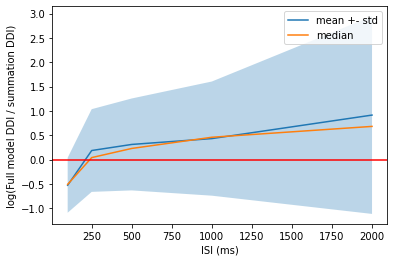

In [18]:
logratio = np.log(all_fm_ddi / all_sum_ddi)
the_mean = np.nanmean(logratio, 0)
the_std = np.nanstd(logratio, 0)
plt.fill_between(cfg.ISIs, the_mean+the_std, the_mean-the_std, alpha=.3)
plt.plot(cfg.ISIs, the_mean, label='mean +- std')
plt.plot(cfg.ISIs, np.nanmedian(logratio, 0), label='median')
plt.axhline(0, color='r')
plt.legend()
plt.ylabel('log(Full model DDI / summation DDI)')
plt.xlabel('ISI (ms)');

# 500 ms ISI
## Hypothesis: STD lowers standard response more than other responses (dev, msc, msc-nontarget)

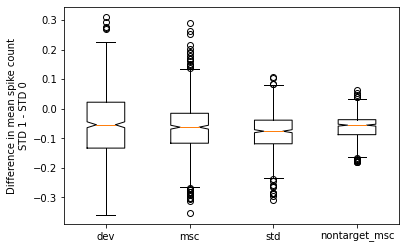

In [19]:
spikediff = []
conditions = ('dev', 'msc', 'std', 'nontarget_msc')
query = dict(isi=500, TA=1)
STD_off = {**query, 'STD': 0}
STD_on = {**query, 'STD': 1}

for i, cond in enumerate(conditions):
    on, off = nspikes[cond][ii.getindex(cfg, **STD_on)], nspikes[cond][ii.getindex(cfg, **STD_off)]
    if cond == 'std':
        on = np.flip(on, ii.getaxis('stim', **STD_on))
        off = np.flip(off, ii.getaxis('stim', **STD_off))
    on, off = on.mean((-1)), off.mean((-1))  # Mean across pulses
    spikediff.append((on-off).flatten())
plt.boxplot(spikediff, notch=True)
plt.ylabel('Difference in mean spike count\nSTD 1 - STD 0')
plt.xticks(np.arange(len(conditions))+1, labels=conditions);

std looks a little bit lower than the other items, but only by a tiny margin. Maybe the difference comes out better if we contrast target vs non-target?

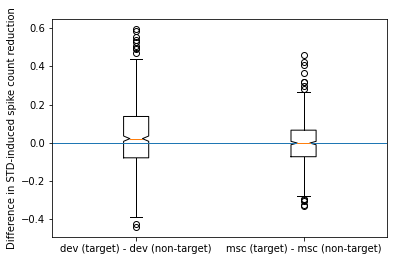

In [20]:
plt.boxplot((spikediff[0]-spikediff[2], spikediff[1]-spikediff[3]), notch=True)
plt.axhline(0, lw=1)
plt.ylabel('Difference in STD-induced spike count reduction')
plt.xticks((1,2), ('dev (target) - dev (non-target)', 'msc (target) - msc (non-target)'));

Yeah, that's significant: msc target and non-target responses are reduced equally by the introduction of STD, whereas std is reduced more than dev.

Let's see if the effect is bigger if I control for the absolute response magnitude:

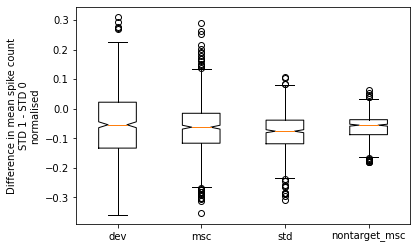

In [21]:
spikediff_normed = []
for i, cond in enumerate(conditions):
    on, off = nspikes[cond][ii.getindex(cfg, **STD_on)], nspikes[cond][ii.getindex(cfg, **STD_off)]
    if cond == 'std':
        on = np.flip(on, ii.getaxis('stim', **STD_on))
        off = np.flip(off, ii.getaxis('stim', **STD_off))
    on, off = on.mean((-1)), off.mean((-1))
    spikediff_normed.append(((on-off)/(on+off)).flatten())
plt.boxplot(spikediff, notch=True)
plt.ylabel('Difference in mean spike count\nSTD 1 - STD 0\nnormalised')
plt.xticks(np.arange(len(conditions))+1, labels=conditions);

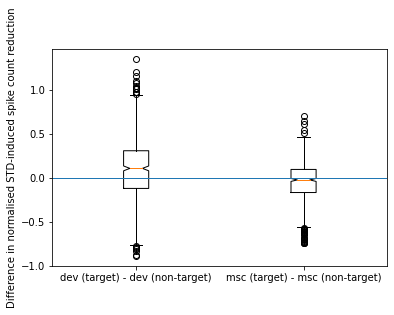

In [22]:
plt.boxplot((spikediff_normed[0]-spikediff_normed[2], spikediff_normed[1]-spikediff_normed[3]), notch=True)
plt.axhline(0, lw=1)
plt.ylabel('Difference in normalised STD-induced spike count reduction')
plt.xticks((1,2), ('dev (target) - dev (non-target)', 'msc (target) - msc (non-target)'));

Yeah, that's looking fairly robust. We could regress these two differences against the improved deviance detection to get a clearer causal link, perhaps, but for now, I'm happy with this level of detail.

# 100 ms ISI
First, let's establish what is actually happening at the short-ISI end.

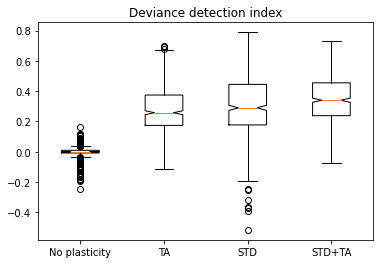

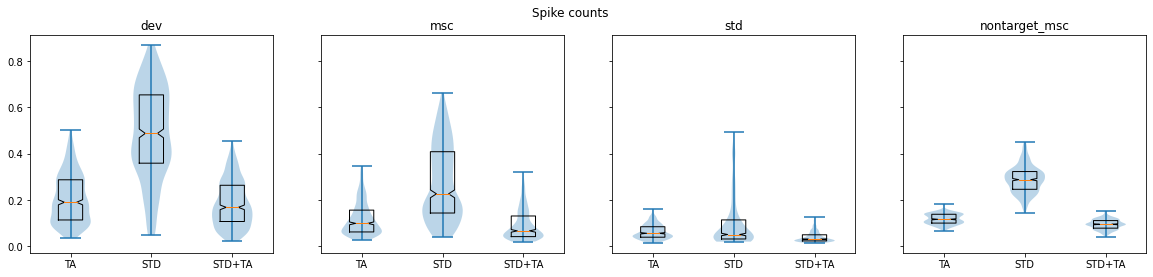

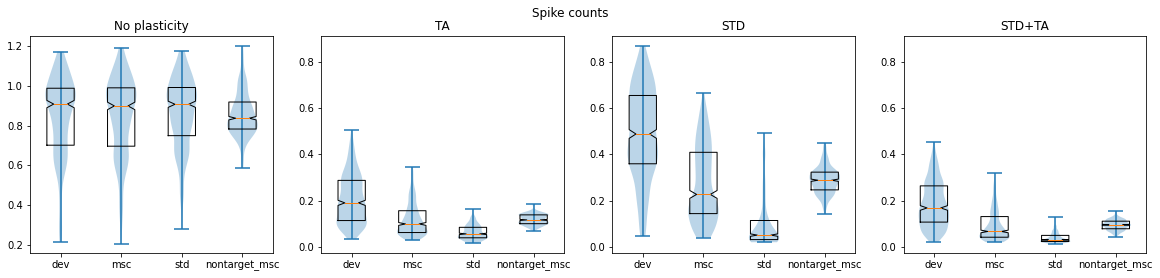

In [23]:
conditions = ('dev', 'msc', 'std', 'nontarget_msc')
query = dict(isi=100)
n = [nspikes[cond][ii.getindex(cfg, **query)[:-1]].mean(-1)
     for cond in conditions]
moveaxis_kw = dict(source=ii.getaxis(('STD', 'TA'), **query), destination=(-2,-1))  # ..., STD, TA
plasticities = ('No plasticity', 'TA', 'STD', 'STD+TA')

ddi = np.moveaxis((n[0]-n[1])/(n[0]+n[1]), **moveaxis_kw)
plt.boxplot(ddi.reshape(-1, 4), notch=True)
plt.xticks(range(1,5), plasticities)
plt.title('Deviance detection index')

fig, axs = plt.subplots(1,4,figsize=(20,4), sharey=True)
fig.suptitle('Spike counts')
for ax, nc, cond in zip(axs, n, conditions):
    nc = np.moveaxis(nc, **moveaxis_kw)
    ax.violinplot(nc.reshape(-1, 4)[:, 1:])
    ax.boxplot(nc.reshape(-1, 4)[:, 1:], notch=True, whis=False, showfliers=False, showcaps=False)
    ax.set_xticks(range(1,4), plasticities[1:])
    ax.set_title(cond)

fig, axs = plt.subplots(1,4,figsize=(20,4))
axs[1].get_shared_y_axes().join(axs[1], *axs[1:])
fig.suptitle('Spike counts')
for i, (ax, plast) in enumerate(zip(axs, plasticities)):
    nc = [np.moveaxis(n_, **moveaxis_kw).reshape(-1, 4)[:, i] for n_ in n]
    ax.violinplot(nc)
    ax.boxplot(nc, notch=True, whis=False, showfliers=False, showcaps=False)
    ax.set_xticks(range(1,5), conditions)
    ax.set_title(plast)

Observations:

1. There is *some* cooperativity: The DDI for the joint model is greater than that for either of the individual mechanisms. Not anywhere near the summation of the two, but also not any less than either, on average.
2. The standard response is pretty tiny in all three plastic models. In contrast, the STD model allows large responses to infrequent stimuli. This makes intuitive sense: With an average of 5 pulses (500 ms) between presentations of the same stimulus, depression close to the stimulation site has time to recover.
3. Other than that, I don't see any obvious effects of plasticity type.

Since spike counts seem unable to explain why STD and TA do not add up, we'll turn to the dynamics.